In [1]:
import numpy
import matplotlib.pyplot as plt

# Principal Component Analysis

Principal Component Analysis(PCA) is an extremely useful exploratory data analysis procedure. It allows interpretation of a a dataset prior to model building and exploration using techniques such as MCMC.

It is useful for analysing correlations in datasets, and allows dimensionality _reduction_, which can vastly simplify model building by allowing you to select only the most important parameters of the data. 

Lets start by defining a data matrix $X$ of dimensions $N \times P$ where N is the number of data samples and P is the number of variables:

$$\begin{bmatrix} 
\theta_{0,0} & \theta_{0,1} & \cdots & \theta_{0,M} \\ 
\theta_{1,0} & \theta_{1,1} & \cdots & \theta_{1,M} \\ 
\vdots & \vdots & \vdots & \vdots \\ 
\theta_{N,0} & \cdots & \cdots & \theta_{N,M} \end{bmatrix}$$

From this we next define a $P \times P$ covariance matrix: 

$$C = \frac{X^{T}X}{n-1}$$

Where the covariance is defined as:

$$Cov = \Sigma^N_{i=0}\frac{\big(X_{i,\theta} - \bar{X_\theta}\big)\big(X_{i,\phi} - \bar{X_\phi}\big)}{N-1}$$

Where $\theta$ and $\phi$ are the variables of the data.

It follows that this covariance matrix can be diagonalized, such that, $ C = VLV^T $ where V is a matrix of the eigenvectors of matrix $C$, where $L$ is a diagonal matrix of the eigenvalues. The eigenvalues lie in order along the diagonal of this matrix.

$L$ contains the _principal components_ of the linear system, or data, we are working with. The $i-th$ principal component is given by the $i-th$ column of $XV$. 

## Eigenvector Analysis: HERA Telescope 

Here is an example using the principle components of the system to understand the correlation between elements in the system. This is a direct example of when I was trying to work out some instrumental effects in a radio telescope: The Hydrogen Epoch of Reionisation Array(HERA).

We form a $N \times 2$ data matrix $X$, diagonalize its covariance matrix, and then use that to plot the correlated and uncorrelated elements by multiplying the data matrix $X$ by the transpose of the eigenvectors: $XV^T$. The uncorrelated elements is the orthogonal eigenvector.

Mean circular sigma: 0.536610
Mean noise to signal ratio: 0.664945
Coveriance: 
[[ 0.28790633  0.2679063 ]
 [ 0.2679063   0.42010968]]
EigenValues: 
[ 0.0780674   0.62994861]
Eigenvectors: 
[[-0.78725802 -0.61662372]
 [ 0.61662372 -0.78725802]]


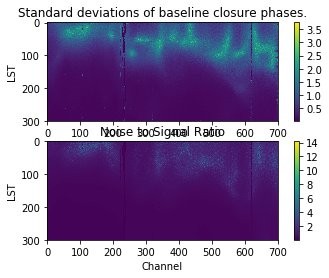

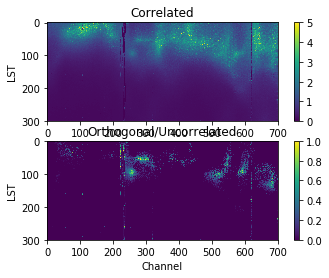

In [2]:
## Load our Numpy Arrays

sigma = numpy.load("dataset/sigma_reduced.npz")
nsr_l = numpy.load("dataset/nsr_reduced.npz")
sigma = sigma['sigma']
nsr_l = nsr_l['nsr_l']

## Print means, we can kinda of eyeball this to check normalistion.
# Note: Lack of normalisation will heavily skew eigenvalues.
print("Mean circular sigma: %f"%(numpy.mean(sigma)))
print("Mean noise to signal ratio: %f"%(numpy.mean(nsr_l)))


## Get rid of any Nans
nsr_l = numpy.nan_to_num(nsr_l)

## Calculate our covariance
cov1d = numpy.cov(sigma.flatten(),nsr_l.flatten())

print("Coveriance: ")
print(cov1d)

## Diagonalise our covariance.
eigvalues,eigvectors = numpy.linalg.eig(cov1d)
print("EigenValues: ")
print(eigvalues)
print("Eigenvectors: ")
print(eigvectors)
eigvectors = eigvectors.T

## Form our data matrix
stack = numpy.vstack((sigma.flatten(),nsr_l.flatten())).T

## Multiply by orthogonal eigenvectors to derive correlated and uncorrelated parts of data.
sumeigs = numpy.dot(stack,eigvectors)
sumeigs = sumeigs.reshape(sigma.shape[0],sigma.shape[1],2)



## Plot correlated and uncorrelated parts.

fig=plt.figure(0)
ax = fig.add_subplot(2,1,1)
plt.imshow(sigma.T)
plt.colorbar()
plt.ylabel("LST")
plt.title("Standard deviations of baseline closure phases.")
ax2 = fig.add_subplot(2,1,2)
plt.imshow(nsr_l.T)
plt.colorbar()
plt.xlabel("Channel")
plt.ylabel("LST")
plt.title("Noise to Signal Ratio")
plt.show()

fig = plt.figure(1)
ax = fig.add_subplot(2,1,1)
plt.imshow(numpy.abs(sumeigs[:,:,0].T))
plt.colorbar()
plt.clim(0,5)
plt.ylabel("LST")
plt.title("Correlated")
ax2 = fig.add_subplot(2,1,2)
plt.imshow(sumeigs[:,:,1].T)
plt.colorbar()
plt.clim(0,1)
plt.xlabel("Channel")
plt.ylabel("LST")
plt.title("Orthogonal/Uncorrelated")
plt.show()



# Dimensionality Reduction

One of the greatest properties of PCA is its ability to allow you to reduce the dimensionality of the data whilst maintaining structure. (Pretty sure it's mathematically impossible to do any better? Any mathematicians able to confirm?)

The eigenvalues in matrix $L$ can be selected so that we only select eigenvalues that are non-trivial. Eigenvalues that are very small indicate that dimension of the data doesn't tell us too much of interest and it _may_ be a good idea to remove those dimensions to simplify modelling. Provided we don't remove large eigenvalues(which indicate something interesting in the data), the data structure will likely be maintained fairly well.

To do this we select $k$ eigenvalues, $\lambda_1,\lambda_2,\cdots,\lambda_k$ of interest and select the upper-left $k \times k$ portion of the eigenvalue matrix $L$ and $k$ columns of the eigenvectors $L$.

Then we form a new principal component data matrix $X_{k} = V_{k}L_{k}V_{k}^T$. The matrix is still of size $N \times P$ but is of _lower rank_, which can be calculated using the standard row-echelon form.

## Example

In the absense of a real dataset for this example, we can create one quite easily by sampling some multivariate gaussian with a covariance matrix of our own design. Let's do that:

In [3]:
## Define a covariance matrix
cov = [[10.0,0,0,0],\
       [0,10,0.5,0],  \
       [0,0.5,10.0,0.5],  \
       [0,0,0.5,12.0]] 
mean = [1,2,3,4] 

data_points = 100
data_matrix = numpy.zeros(shape=(data_points,numpy.shape(mean)[0]))

## Create some gaussian distributed dataset.
for i in numpy.arange(data_points):
    data_matrix[i] = numpy.random.multivariate_normal(mean,cov)

### Now we reduce the rank of the data matrix.

(4, 4)


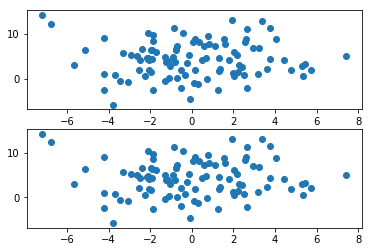

In [4]:
## Just assume we didn't generate the dataset above, and that we've just been given it
covariance_dataset = numpy.cov(data_matrix.T)
print(numpy.shape(covariance_dataset))

## Diagonalise
eigvalues,eigvectors = numpy.linalg.eig(covariance_dataset)

## Reduce rank of data
eigvalk = numpy.zeros(shape=eigvectors.shape)
eigveck = numpy.zeros(shape=eigvectors.shape)

#Number of eigenvalues/vectors we wish to select.
k = 2

for i in numpy.arange(k):
    eigveck[:,i] = eigvectors[:,i]
    eigvalk[i,i] = eigvalues[i]
    
dreduced_dataset = numpy.dot(data_matrix,eigveck)

## Plot original vs reduced dataset for first two dimensions

# Make sure to put original dataset into component space first!

data_matrix_pc = numpy.dot(data_matrix,eigvectors)

# We have reduced the rank of our dataset, making modelling easier, however the rest of its structure is retained!
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
plt.scatter(data_matrix_pc[:,0],data_matrix_pc[:,1])
ax2 = fig.add_subplot(2,1,2)
plt.scatter(dreduced_dataset[:,0],dreduced_dataset[:,1])

plt.show()